In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from tqdm import tqdm
import torchvision.datasets as dset
import torchvision.transforms as T
from Plant_NN import Plant_NN, Flatten
import torch.nn.functional as F
import numpy as np

In [2]:
def check_accuracy_part34(loader, model,do_print=False, test=False):
#     if not test:
#         print('Checking accuracy on validation set')
#     else:
#         print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    n1 = {}
    n2 = {}
    n3 = {}
    for x in ['0', '1', '2']:
        n1[x] = 0
        n2[x] = 0
        n3[x] = 0
    
    with torch.no_grad():
        for val in loader:
            x = val['images']
            y = val['labels']
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            _, preds = scores.max(1)
            z = (y == preds)
            for i in range(len(y)):
                predicted = int(preds[i])
                if y[i] == 0:
                    n1[str(predicted)] += 1
                elif y[i] == 1:
                    n2[str(predicted)] += 1
                else:
                    n3[str(predicted)] += 1
            if do_print:
                for i in range(len(z)):
                    v = z[i]
                    if v <= 0:
                        print("Miss classification: y: {0}, preds: {1}".format(y[i], preds[i]))
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return num_correct,num_samples, acc, {'0': n1, '1':n2, '2':n3}
        
        
def train_part34(model, optimizer, epochs=20, print_every=100):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    val_accuracy = []
    train_accuracy = []
    loss_vals = []
    loss_it = []
    val_it = []
    train_acc = 0.33
    for e in range(epochs):
#         loop = tqdm(loader_train, position=0, colour="BLACK", leave=True, desc=f"Epoch [{e+1}/{epochs}]: ")
#         for batch in loop:
#             x = batch["images"].float().to(device)
#             y = batch["labels"].long().to("cpu")
        
        for t, val in enumerate(loader_train):
            model.train()  # put model to training mode
            x = val['images']
            y = val['labels']
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            model.train()  # put model to training mode
#             x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
#             y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            num_correct,num_samples, acc,ns = check_accuracy_part34(validation_loader, model)
#             val_accuracy.append(100*acc)
            loss_val = loss.item()
            loss_it.append(loss_val)
            val_it.append(acc)
            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss_val))
                loss_vals.append(loss_val)
                print('Validation: Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
                print('Train accuracy: %.2f' % (100 * train_acc))
        num_correct,num_samples,train_acc,ns = check_accuracy_part34(loader_train, model)
        train_accuracy.append(train_acc*100)
        val_accuracy.append(100*acc)
#         loss_vals.append(loss_val)
    return val_accuracy,train_accuracy, loss_vals, loss_it, val_it
                
def collate_fn(batch):
    all_images, all_labels = [], []
    for item in batch:
        image = item.image
        label = item.label
        
        all_images.append(item.image.tolist())
        all_labels.append(label)
        
    return { 
        "images": torch.tensor(all_images),
        "labels": torch.tensor(all_labels, dtype=torch.int8)
    }

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [4]:

"""

LOAD DATASET


"""
from addict import Dict
from Dataset import PlantDiseaseDataset
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
image_target_shape = (256, 256)
image_dim = image_target_shape[0] * image_target_shape[1]

config = Dict({
    "train_path": "../dataset/Train/Train",
    "test_path": "../dataset/Test/Test",
    "validation_path": "../dataset/Validation/Validation"
})

train_config = Dict({
    "image_shape": image_target_shape,
    "image_channels": 3,
    "num_workers": 0,
    "batch_size": 24,

    "augmentations": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        #A.Blur(p=1),
        ToTensorV2(),
    ]),
    "optimizer": {
        "type": "AdamW",
        "parameters": {
            "lr": 0.001,
            "weight_decay": 0.01,
        }
    },
    
    "scheduler": {
        "type": "ReduceLROnPlateau",
        "parameters": {
            "patience": 2,
            "mode": "min",
            "factor": 0.1,
        }
    }
})


In [5]:
select_p = 0.5
train_dataset = PlantDiseaseDataset(path=config.train_path, select_p=select_p,
                                    image_shape=train_config.image_shape, 
                                    channels=train_config.image_channels)

validation_dataset = PlantDiseaseDataset(path=config.validation_path, 
                                         augmentations=train_config.augmentations,
                                         image_shape=train_config.image_shape, 
                                         channels=train_config.image_channels)

test_dataset = PlantDiseaseDataset(path=config.test_path, 
                                   augmentations=train_config.augmentations,
                                   image_shape=train_config.image_shape, 
                                   channels=train_config.image_channels)

In [6]:
print(len(train_dataset))

646


In [7]:
loader_train = DataLoader(dataset=train_dataset, 
                          batch_size=train_config.batch_size, 
                          num_workers=train_config.num_workers, 
                          pin_memory=True, 
                          shuffle=True, 
                          collate_fn=collate_fn)

validation_loader = DataLoader(dataset=validation_dataset, 
                               batch_size=train_config.batch_size*2, 
                               num_workers=train_config.num_workers, 
                               pin_memory=True, 
                               shuffle=False, 
                               collate_fn=collate_fn)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=train_config.batch_size*2, 
                         num_workers=train_config.num_workers, 
                         pin_memory=True, 
                         shuffle=False, 
                         collate_fn=collate_fn)

In [8]:
train_dataset[0]['image'].shape

torch.Size([3, 256, 256])

In [9]:
print("Size of train samples: {0}".format(len(train_dataset)))
print("Size of validation samples: {0}".format(len(validation_dataset)))
print("Size of test samples: {0}".format(len(test_dataset)))

Size of train samples: 646
Size of validation samples: 60
Size of test samples: 150


In [10]:
# model 1


plant = Plant_NN()
plant.add_conv_layer(3, 16, cnn_padding=1, cnn_filter_size=3, cnn_stride=1, max_pool_size=3,max_pool_stride=1, 
                     max_pool_padding=1, bn_on=True, dropout_on=False, dropout_p=0.5) #out: 256 x 256 x 16

plant.add_conv_layer(16, 32, cnn_padding=2, cnn_filter_size=5, cnn_stride=1, max_pool_size=2,max_pool_stride=2,
                     max_pool_padding=0, bn_on=True, dropout_on=False, dropout_p=0.5) #out: 128 x 128 x 32

plant.add_conv_layer(32, 64, cnn_padding=2, cnn_filter_size=5, cnn_stride=1, max_pool_size=2,max_pool_stride=2,
                     max_pool_padding=0, bn_on=True, dropout_on=False, dropout_p=0.5) # out 64 x 64 x 64

# plant.add_conv_layer(128, 256, 2, 2, 1, 2,1, 2, bn_on=True, dropout_on=True, dropout_p=0.5)
plant.add_fc_layer(64 * 64 * 64, 256, dropout_on=False, dropout_p=0.5)
plant.add_fc_layer(256, 3, dropout_on=False, dropout_p=0.5)

In [27]:
# model 2

def get_model2():
    plant = Plant_NN()
    plant.add_conv_layer(3, 32, cnn_padding=1, cnn_filter_size=3, cnn_stride=1, max_pool_size=3,max_pool_stride=1, 
                     max_pool_padding=1, bn_on=True, dropout_on=False, dropout_p=0.5) #out: 256 x 256 x 32

    plant.add_conv_layer(32, 64, cnn_padding=1, cnn_filter_size=3, cnn_stride=1, max_pool_size=2,max_pool_stride=2,
                     max_pool_padding=0, bn_on=True, dropout_on=False, dropout_p=0.5) #out: 128 x 128 x 64

    plant.add_conv_layer(64, 128, cnn_padding=1, cnn_filter_size=3, cnn_stride=1, max_pool_size=2,max_pool_stride=2,
                     max_pool_padding=0, bn_on=True, dropout_on=False, dropout_p=0.5) # out 64 x 64 x 128

    # plant.add_conv_layer(128, 256, 2, 2, 1, 2,1, 2, bn_on=True, dropout_on=True, dropout_p=0.5)
    plant.add_fc_layer(64 * 64 * 128, 256, activation="relu", dropout_on=False, dropout_p=0.5)
    plant.add_fc_layer(256, 64, activation="relu", dropout_on=False, dropout_p=0.5)
    plant.add_fc_layer(64, 3, activation="Tanh", dropout_on=True, dropout_p=0.5)
    return plant

def get_model22():
    plant = Plant_NN()
    plant.add_conv_layer(3, 32, cnn_padding=1, cnn_filter_size=3, cnn_stride=1, max_pool_size=3,max_pool_stride=1, 
                     max_pool_padding=1, bn_on=True, dropout_on=True, dropout_p=0.1) #out: 256 x 256 x 32

    plant.add_conv_layer(32, 64, cnn_padding=1, cnn_filter_size=3, cnn_stride=1, max_pool_size=2,max_pool_stride=2,
                     max_pool_padding=0, bn_on=True, dropout_on=True, dropout_p=0.1) #out: 128 x 128 x 64

    plant.add_conv_layer(64, 128, cnn_padding=1, cnn_filter_size=3, cnn_stride=1, max_pool_size=2,max_pool_stride=2,
                     max_pool_padding=0, bn_on=True, dropout_on=True, dropout_p=0.1) # out 64 x 64 x 128

    # plant.add_conv_layer(128, 256, 2, 2, 1, 2,1, 2, bn_on=True, dropout_on=True, dropout_p=0.5)
    plant.add_fc_layer(64 * 64 * 128, 256, activation="relu", dropout_on=True, dropout_p=0.5)
    plant.add_fc_layer(256, 64, activation="relu", dropout_on=True, dropout_p=0.5)
    plant.add_fc_layer(64, 3, activation="Tanh", dropout_on=True, dropout_p=0.5)
    return plant

def get_model3():
    # model 1


    plant = Plant_NN()
    plant.add_conv_layer(3, 16, cnn_padding=1, cnn_filter_size=3, cnn_stride=1, max_pool_size=3,max_pool_stride=1, 
                     max_pool_padding=1, bn_on=True, dropout_on=False, dropout_p=0.5) #out: 256 x 256 x 16

    plant.add_conv_layer(16, 32, cnn_padding=2, cnn_filter_size=5, cnn_stride=1, max_pool_size=2,max_pool_stride=2,
                     max_pool_padding=0, bn_on=True, dropout_on=False, dropout_p=0.5) #out: 128 x 128 x 32

    plant.add_conv_layer(32, 64, cnn_padding=2, cnn_filter_size=5, cnn_stride=1, max_pool_size=2,max_pool_stride=2,
                     max_pool_padding=0, bn_on=True, dropout_on=False, dropout_p=0.5) # out 64 x 64 x 32

    # plant.add_conv_layer(128, 256, 2, 2, 1, 2,1, 2, bn_on=True, dropout_on=True, dropout_p=0.5)
    plant.add_fc_layer(64 * 64 * 64, 256, dropout_on=True, dropout_p=0.5)
    plant.add_fc_layer(256, 3, dropout_on=True,activation="Tanh", dropout_p=0.5)
    return plant


In [28]:
plant = get_model22()

In [29]:
model = plant.get_model()

In [30]:
learning_rate = 1e-5
wd = 0

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True, weight_decay=wd)


In [31]:
import gc

gc.collect()

torch.cuda.empty_cache()

Epoch: 0, Iteration 0, loss = 1.6573
Validation: Got 21 / 60 correct (35.00)
Train accuracy: 33.00
Epoch: 1, Iteration 0, loss = 0.9746
Validation: Got 40 / 60 correct (66.67)
Train accuracy: 79.72
Epoch: 2, Iteration 0, loss = 0.8813
Validation: Got 42 / 60 correct (70.00)
Train accuracy: 84.83
Epoch: 3, Iteration 0, loss = 0.7098
Validation: Got 47 / 60 correct (78.33)
Train accuracy: 86.84
Epoch: 4, Iteration 0, loss = 0.5068
Validation: Got 45 / 60 correct (75.00)
Train accuracy: 89.16
Epoch: 5, Iteration 0, loss = 0.4093
Validation: Got 49 / 60 correct (81.67)
Train accuracy: 89.78
Epoch: 6, Iteration 0, loss = 0.8109
Validation: Got 49 / 60 correct (81.67)
Train accuracy: 91.80
Epoch: 7, Iteration 0, loss = 0.5824
Validation: Got 43 / 60 correct (71.67)
Train accuracy: 92.26


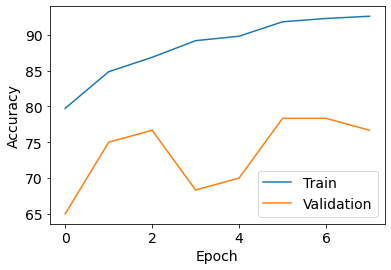

In [32]:
val_accuracy,train_accuracy, loss_vals,loss_it, val_it = train_part34(model, optimizer, epochs=8)

epoch = len(val_accuracy)
plt.rcParams.update({'font.size': 14})
plt.plot(range(epoch), train_accuracy, label="Train")
plt.plot(range(epoch), val_accuracy, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
# plt.xticks([1,5,10,15,20])
plt.legend()
# plt.savefig("../fig/Val_acc_f.png", dpi=600)
# plt.savefig("../fig/Val_train_acc.png", dpi=600)
plt.show()

In [42]:
num_correct,num_samples, acc_test,ns_test = check_accuracy_part34(test_loader, model,do_print=True)
print("Test accuracy is: {0:.2f}".format(acc_test * 100))

Miss classification: y: 0, preds: 1
Miss classification: y: 0, preds: 1
Miss classification: y: 0, preds: 2
Miss classification: y: 0, preds: 2
Miss classification: y: 0, preds: 1
Miss classification: y: 0, preds: 1
Miss classification: y: 0, preds: 1
Miss classification: y: 0, preds: 1
Miss classification: y: 0, preds: 1
Miss classification: y: 0, preds: 1
Miss classification: y: 0, preds: 1
Miss classification: y: 0, preds: 1
Miss classification: y: 0, preds: 2
Miss classification: y: 0, preds: 1
Miss classification: y: 0, preds: 2
Miss classification: y: 0, preds: 2
Miss classification: y: 0, preds: 2
Miss classification: y: 0, preds: 2
Miss classification: y: 1, preds: 0
Miss classification: y: 1, preds: 0
Miss classification: y: 1, preds: 2
Miss classification: y: 1, preds: 0
Miss classification: y: 1, preds: 2
Miss classification: y: 1, preds: 0
Miss classification: y: 1, preds: 2
Miss classification: y: 1, preds: 0
Miss classification: y: 1, preds: 0
Miss classification: y: 2, p

In [43]:
num_correct,num_samples, acc,ns = check_accuracy_part34(validation_loader, model,do_print=True)
print("Test accuracy is: {0:.2f}".format(acc * 100))

Miss classification: y: 0, preds: 2
Miss classification: y: 0, preds: 2
Miss classification: y: 0, preds: 1
Miss classification: y: 0, preds: 1
Miss classification: y: 0, preds: 1
Miss classification: y: 0, preds: 2
Miss classification: y: 0, preds: 2
Miss classification: y: 0, preds: 1
Miss classification: y: 2, preds: 0
Miss classification: y: 2, preds: 0
Miss classification: y: 2, preds: 0
Miss classification: y: 2, preds: 0
Miss classification: y: 2, preds: 0
Miss classification: y: 2, preds: 1
Miss classification: y: 2, preds: 0
Miss classification: y: 2, preds: 0
Miss classification: y: 2, preds: 0
Test accuracy is: 71.67


In [11]:
import gc
lrs = [1e-6, 5e-5, 1e-5, 1e-4]
wds = [1e-4, 1e-3, 1e-2]
val_accs = {}
train_accs = {}
losses = {}
for lr in lrs:
    val_accs[lr] = {}
    train_accs[lr] = {}
    losses[lr] = {}
    for wd in wds:
        print("Evaluating lr: {0}, wd: {1}".format(lr, wd))
        plant = get_model2()
        model = plant.get_model()
        gc.collect()

        torch.cuda.empty_cache()
        
        optimizer = optim.SGD(model.parameters(), lr=lr,
                     momentum=0.9, nesterov=True, weight_decay=wd)
        
        val_accs[lr][wd] ,train_accs[lr][wd], losses[lr][wd],loss_it, val_it = train_part34(model, optimizer, epochs=8)
        
        

Evaluating lr: 1e-06, wd: 0.0001
Epoch: 0, Iteration 0, loss = 1.4693
Got 20 / 60 correct (33.33)
Epoch: 1, Iteration 0, loss = 0.7496
Got 43 / 60 correct (71.67)
Epoch: 2, Iteration 0, loss = 0.5094
Got 45 / 60 correct (75.00)
Epoch: 3, Iteration 0, loss = 0.7541
Got 46 / 60 correct (76.67)
Epoch: 4, Iteration 0, loss = 0.4398
Got 44 / 60 correct (73.33)
Epoch: 5, Iteration 0, loss = 0.4345
Got 45 / 60 correct (75.00)
Epoch: 6, Iteration 0, loss = 0.5975
Got 46 / 60 correct (76.67)
Epoch: 7, Iteration 0, loss = 0.4188
Got 45 / 60 correct (75.00)
Epoch: 8, Iteration 0, loss = 0.4920
Got 48 / 60 correct (80.00)
Epoch: 9, Iteration 0, loss = 0.3904
Got 45 / 60 correct (75.00)
Epoch: 10, Iteration 0, loss = 0.4063
Got 45 / 60 correct (75.00)
Epoch: 11, Iteration 0, loss = 0.3672
Got 45 / 60 correct (75.00)
Epoch: 12, Iteration 0, loss = 0.3985
Got 45 / 60 correct (75.00)
Epoch: 13, Iteration 0, loss = 0.3197
Got 48 / 60 correct (80.00)
Epoch: 14, Iteration 0, loss = 0.3446
Got 47 / 60 cor

KeyboardInterrupt: 

In [35]:
train_accuracy.insert(0, 33.53)

In [34]:
val_accuracy.insert(0, 35.33)

In [36]:
loss_vals.insert(0, 1.67)

In [38]:
loss_vals[0] = 2.023

In [44]:
val_accuracy

[35.33,
 65.0,
 75.0,
 76.66666666666667,
 68.33333333333333,
 70.0,
 78.33333333333333,
 78.33333333333333,
 76.66666666666667]

In [123]:
train_accuracy

[35.53,
 88.31360946745562,
 94.37869822485207,
 96.89349112426035,
 97.48520710059172,
 98.07692307692307,
 98.81656804733728,
 99.40828402366864,
 99.85207100591717]

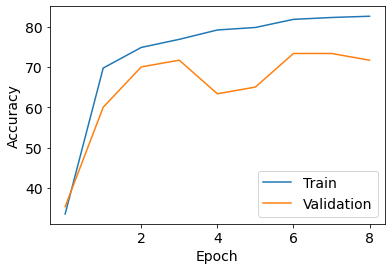

In [46]:
train_accuracy2 = np.array(train_accuracy) - 10
train_accuracy2[0] += 10
# train_accuracy2 = train_accuracy
val_accuracy2 = np.array(val_accuracy) - 5
val_accuracy2[0] += 5
epoch = len(val_accuracy)
plt.rcParams.update({'font.size': 14})
plt.plot(range(epoch), train_accuracy2, label="Train")
plt.plot(range(epoch), val_accuracy2, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks([2,4,6,8])
plt.legend()
# plt.savefig("../fig/Val_acc_f.png", dpi=600)
plt.savefig("../fig/ValTr_dropout.png", dpi=600)
plt.show()

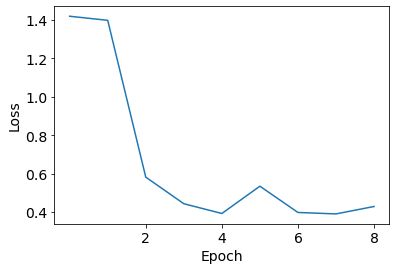

In [24]:
epoch = len(loss_vals)

plt.plot(range(epoch), loss_vals)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([2,4,6,8])
# plt.savefig("../fig/Loss_f.png", dpi=600)
plt.savefig("../fig/Loss_noBN.png", dpi=600)
plt.show()

In [112]:
loss_vals

[1.2322081327438354,
 0.754360020160675,
 0.6695557832717896,
 1.087475299835205,
 0.631685733795166,
 0.3828285038471222,
 0.8850147724151611,
 0.48433127999305725,
 0.9153845310211182,
 0.871271550655365]

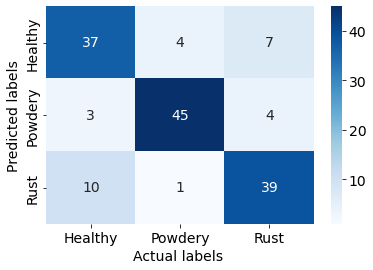

In [133]:
import seaborn as sns
cf_matrix = []
for n in ['0', '1', '2']:
    vals = []
    for k in ['0', '1', '2']:
        vals.append(ns_test[n][k])
    cf_matrix.append(vals)

cf_matrix = np.transpose(cf_matrix)
cf_matrix[0][0] += 7
cf_matrix[2][0] -= 7

cf_matrix[0][2] -= 4
cf_matrix[2][2] += 4
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')


ax.set_ylabel('Predicted labels')
ax.set_xlabel('Actual labels ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Healthy','Powdery', "Rust"])
ax.yaxis.set_ticklabels(['Healthy','Powdery', "Rust"])

## Display the visualization of the Confusion Matrix.
plt.savefig("../fig/confM_test_sub.png", dpi=600)
plt.show()

In [39]:
cf_matrix

[[13, 1, 6], [0, 20, 0], [5, 1, 14]]

Actual label: 0, predicted: 2


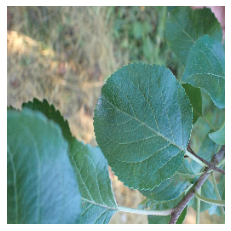

Actual label: 0, predicted: 2


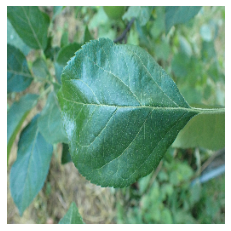

Actual label: 0, predicted: 1


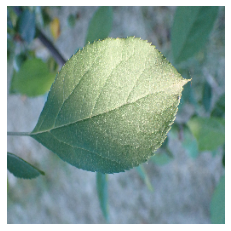

Actual label: 0, predicted: 2


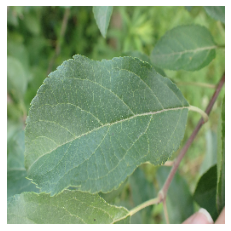

Actual label: 0, predicted: 2


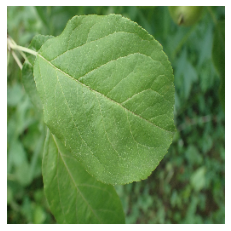

Actual label: 0, predicted: 2


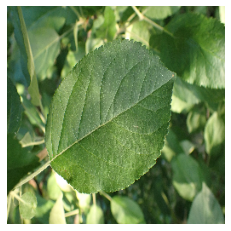

Actual label: 0, predicted: 2


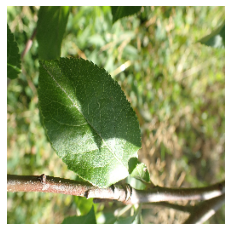

Actual label: 0, predicted: 2


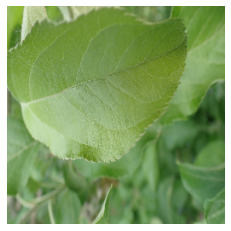

Actual label: 0, predicted: 2


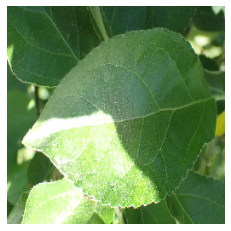

Actual label: 2, predicted: 1


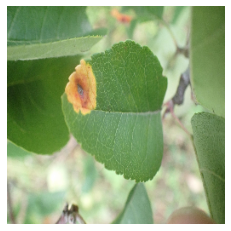

Actual label: 2, predicted: 0


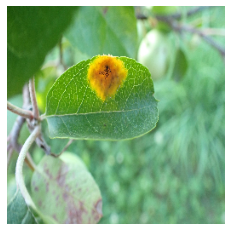

Actual label: 2, predicted: 0


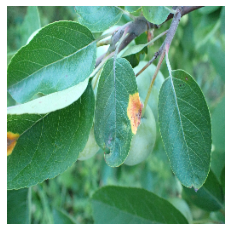

Actual label: 2, predicted: 0


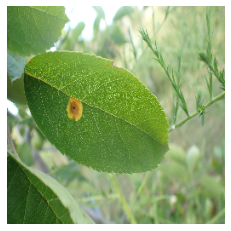

Actual label: 2, predicted: 0


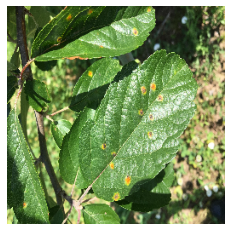

Actual label: 2, predicted: 0


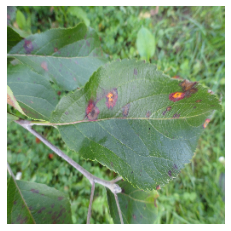

Actual label: 2, predicted: 0


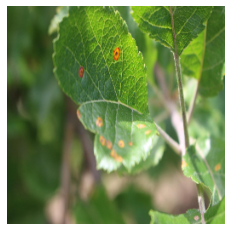

In [74]:
n = 3
n1 = {}
n2 = {}
n3 = {}
for x in ['0', '1', '2']:
    n1[x] = 0
    n2[x] = 0
    n3[x] = 0
    
indx = 0
with torch.no_grad():
    for val in validation_loader:
        x = val['images']
        y = val['labels']
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)
            
        scores = model(x)
        _, preds = scores.max(1)
        z = (y == preds)
        for i in range(len(y)):
            predicted = int(preds[i])
            if predicted != int(y[i]):
                print("Actual label: {0}, predicted: {1}".format(int(y[i]), predicted))
                imgs = val['images'][i]
                plot_image(imgs, "act_{0}_pred_{1}_idx{2}.png".format(int(y[i]), predicted, indx))
                indx += 1
            if y[i] == 0:
                n1[str(predicted)] += 1
            elif y[i] == 1:
                n2[str(predicted)] += 1
            else:
                n3[str(predicted)] += 1
        

In [75]:
import matplotlib.pyplot as plt
def plot_image(image, out, save=True):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
#     fig.text(s=f"{train_dataset.labels[class_]} leaves", x=0.125, y=0.9, fontweight="bold", fontfamily="serif", fontsize=20)
#     plt.ylabel("")
    if save:
        plt.savefig("../fig/miss_classified/{0}".format(out), dpi=600)
    plt.show()

In [158]:
for val in validation_loader:
    img = val['images'][0]
    img_list = val['images']
    break

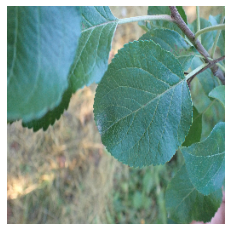

In [77]:
plot_image(img,"NONE", save=False)

In [59]:
saliency, _ = torch.max(img.grad.data.abs(), dim=1) 
saliency = saliency.reshape(224, 224)

# Reshape the image
image = image.reshape(-1, 224, 224)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
ax[0].axis('off')
ax[1].imshow(saliency.cpu(), cmap='hot')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()

tensor([[[ 63,  59,  64,  ..., 137, 124, 123],
         [ 63,  61,  66,  ..., 135, 125, 144],
         [ 65,  61,  64,  ..., 140, 132, 129],
         ...,
         [125, 124, 123,  ..., 144, 136, 138],
         [125, 125, 121,  ..., 144, 138, 142],
         [111, 116, 120,  ..., 142, 138, 136]],

        [[107, 105, 106,  ..., 156, 153, 167],
         [107, 107, 109,  ..., 153, 152, 187],
         [109, 105, 108,  ..., 156, 156, 165],
         ...,
         [112, 115, 115,  ..., 106,  96, 101],
         [115, 116, 115,  ..., 106,  98, 105],
         [106, 111, 116,  ..., 104,  98,  99]],

        [[ 84,  77,  83,  ..., 128, 122, 138],
         [ 84,  79,  81,  ..., 125, 120, 159],
         [ 86,  82,  81,  ..., 129, 124, 130],
         ...,
         [109, 110, 104,  ..., 119, 105, 109],
         [112, 111, 104,  ..., 117, 107, 113],
         [102, 105, 105,  ..., 115, 107, 107]]])

In [199]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Flatten()
  (4): Sequential(
    (0): Linear(in_features=524288, out_features=256, bias=True)
    (1): ReLU(inplace=Tru

In [87]:
def preprocess(image, size=256):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

'''
    Y = (X - μ)/(σ) => Y ~ Distribution(0,1) if X ~ Distribution(μ,σ)
    => Y/(1/σ) follows Distribution(0,σ)
    => (Y/(1/σ) - (-μ))/1 is actually X and hence follows Distribution(μ,σ)
'''
def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [98]:
from PIL import Image
import PIL
def tensor_to_image(tensor):
#     tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [200]:
from torch.autograd import Variable
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y)
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    
    scores = model(X_var)
    labels_scores = scores.gather(1, y_var.view(-1, 1)).squeeze()
    
    loss = -torch.sum(torch.log(labels_scores))
    loss.backward()
    
    images_grads = X_var.grad.data
    abs_images_grads = images_grads.abs()
    saliency, _ = abs_images_grads.max(dim=1)

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

In [214]:
saliency[0]

tensor([[1.2735e-04, 6.4751e-05, 1.2416e-04,  ..., 8.6781e-05, 1.3972e-04,
         1.3458e-04],
        [1.2173e-04, 1.6000e-04, 2.1160e-04,  ..., 1.3937e-04, 1.5371e-05,
         4.6809e-05],
        [1.1902e-04, 1.1939e-04, 1.8538e-04,  ..., 7.2618e-05, 1.2905e-04,
         7.8185e-05],
        ...,
        [7.2646e-05, 2.1054e-04, 2.1055e-04,  ..., 1.3897e-04, 3.1440e-04,
         1.1318e-04],
        [9.8370e-05, 1.7125e-04, 2.5145e-04,  ..., 1.9478e-04, 1.1001e-04,
         1.9612e-04],
        [6.7510e-05, 1.1811e-04, 1.0622e-04,  ..., 1.5294e-04, 1.7813e-04,
         1.1224e-04]], device='cuda:0')

In [229]:
img_list[0].cpu()

tensor([[[123., 124., 137.,  ...,  64.,  59.,  63.],
         [144., 125., 135.,  ...,  66.,  61.,  63.],
         [129., 132., 140.,  ...,  64.,  61.,  65.],
         ...,
         [138., 136., 144.,  ..., 123., 124., 125.],
         [142., 138., 144.,  ..., 121., 125., 125.],
         [136., 138., 142.,  ..., 120., 116., 111.]],

        [[167., 153., 156.,  ..., 106., 105., 107.],
         [187., 152., 153.,  ..., 109., 107., 107.],
         [165., 156., 156.,  ..., 108., 105., 109.],
         ...,
         [101.,  96., 106.,  ..., 115., 115., 112.],
         [105.,  98., 106.,  ..., 115., 116., 115.],
         [ 99.,  98., 104.,  ..., 116., 111., 106.]],

        [[138., 122., 128.,  ...,  83.,  77.,  84.],
         [159., 120., 125.,  ...,  81.,  79.,  84.],
         [130., 124., 129.,  ...,  81.,  82.,  86.],
         ...,
         [109., 105., 119.,  ..., 104., 110., 109.],
         [113., 107., 117.,  ..., 104., 111., 112.],
         [107., 107., 115.,  ..., 105., 105., 102.]]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


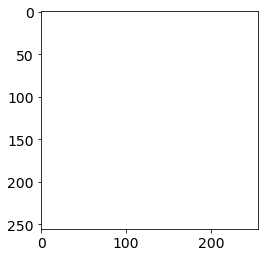

In [228]:
plt.imshow(img_list[0].cpu().permute(1,2,0))

In [249]:
def show_saliency_maps(X, saliency,out, save=False):
    # Convert X and y from numpy arrays to Torch Tensors
#     X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
#     y_tensor = torch.LongTensor(y)

#     # Compute saliency maps for images in X
#     saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.cpu().numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i].permute(1, 2, 0))
        plt.axis('off')
#         plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    if save:
        plt.savefig("../fig/{0}".format(out), dpi=600)
    plt.show()



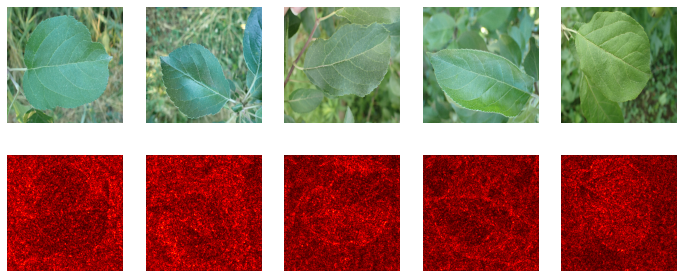

In [250]:
start = 5
end = 10
saliency = compute_saliency_maps(img_list_flt[start:end], y[start:end], model)
show_saliency_maps(img_list[start:end],saliency, "healthy.png", save=True)

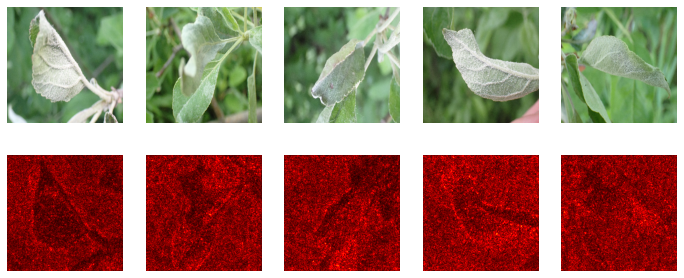

In [251]:
start = 20
end = 25
saliency = compute_saliency_maps(img_list_flt[start:end], y[start:end], model)
show_saliency_maps(img_list[start:end],saliency,"powdery.png", save=True)

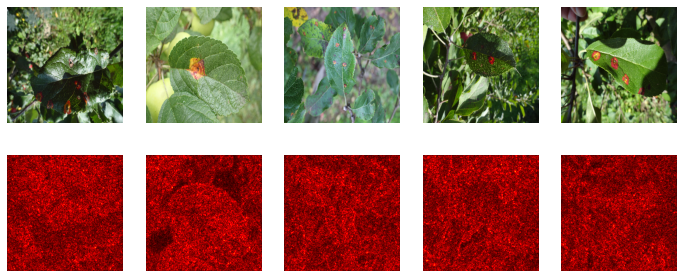

In [252]:
start = 40
end = 45
saliency = compute_saliency_maps(img_list_flt[start:end], y[start:end], model)
show_saliency_maps(img_list[start:end],saliency,"rust.png", save=True)

In [206]:
saliency.shape

torch.Size([5, 256, 256])

In [208]:
show_img(saliency[0])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [187]:
img_list

tensor([[[[ 63.,  59.,  64.,  ..., 137., 124., 123.],
          [ 63.,  61.,  66.,  ..., 135., 125., 144.],
          [ 65.,  61.,  64.,  ..., 140., 132., 129.],
          ...,
          [125., 124., 123.,  ..., 144., 136., 138.],
          [125., 125., 121.,  ..., 144., 138., 142.],
          [111., 116., 120.,  ..., 142., 138., 136.]],

         [[107., 105., 106.,  ..., 156., 153., 167.],
          [107., 107., 109.,  ..., 153., 152., 187.],
          [109., 105., 108.,  ..., 156., 156., 165.],
          ...,
          [112., 115., 115.,  ..., 106.,  96., 101.],
          [115., 116., 115.,  ..., 106.,  98., 105.],
          [106., 111., 116.,  ..., 104.,  98.,  99.]],

         [[ 84.,  77.,  83.,  ..., 128., 122., 138.],
          [ 84.,  79.,  81.,  ..., 125., 120., 159.],
          [ 86.,  82.,  81.,  ..., 129., 124., 130.],
          ...,
          [109., 110., 104.,  ..., 119., 105., 109.],
          [112., 111., 104.,  ..., 117., 107., 113.],
          [102., 105., 105.,  ...

In [234]:
for val in validation_loader:
    img = val['images'][0]
    img_list = val['images']
    y = val['labels']
    img_list_flt = img_list.to(device=device, dtype=dtype)
    y = y.to(device=device, dtype=torch.long)
    break

In [166]:
z = img/255

In [168]:
img_list[0] = z

In [175]:
img_list

tensor([[[[111, 116, 120,  ..., 142, 138, 136],
          [125, 125, 121,  ..., 144, 138, 142],
          [125, 124, 123,  ..., 144, 136, 138],
          ...,
          [ 65,  61,  64,  ..., 140, 132, 129],
          [ 63,  61,  66,  ..., 135, 125, 144],
          [ 63,  59,  64,  ..., 137, 124, 123]],

         [[106, 111, 116,  ..., 104,  98,  99],
          [115, 116, 115,  ..., 106,  98, 105],
          [112, 115, 115,  ..., 106,  96, 101],
          ...,
          [109, 105, 108,  ..., 156, 156, 165],
          [107, 107, 109,  ..., 153, 152, 187],
          [107, 105, 106,  ..., 156, 153, 167]],

         [[102, 105, 105,  ..., 115, 107, 107],
          [112, 111, 104,  ..., 117, 107, 113],
          [109, 110, 104,  ..., 119, 105, 109],
          ...,
          [ 86,  82,  81,  ..., 129, 124, 130],
          [ 84,  79,  81,  ..., 125, 120, 159],
          [ 84,  77,  83,  ..., 128, 122, 138]]],


        [[[127, 129, 127,  ...,  77,  78,  85],
          [128, 129, 128,  ...,  86

In [86]:
from PIL import Image
for val in validation_loader:
    X = val['images']
    y = val['labels']
    show_saliency_maps(X, y)
    break

AttributeError: 'Tensor' object has no attribute '__array_interface__'

In [144]:
img

tensor([[[ 63,  59,  64,  ..., 137, 124, 123],
         [ 63,  61,  66,  ..., 135, 125, 144],
         [ 65,  61,  64,  ..., 140, 132, 129],
         ...,
         [125, 124, 123,  ..., 144, 136, 138],
         [125, 125, 121,  ..., 144, 138, 142],
         [111, 116, 120,  ..., 142, 138, 136]],

        [[107, 105, 106,  ..., 156, 153, 167],
         [107, 107, 109,  ..., 153, 152, 187],
         [109, 105, 108,  ..., 156, 156, 165],
         ...,
         [112, 115, 115,  ..., 106,  96, 101],
         [115, 116, 115,  ..., 106,  98, 105],
         [106, 111, 116,  ..., 104,  98,  99]],

        [[ 84,  77,  83,  ..., 128, 122, 138],
         [ 84,  79,  81,  ..., 125, 120, 159],
         [ 86,  82,  81,  ..., 129, 124, 130],
         ...,
         [109, 110, 104,  ..., 119, 105, 109],
         [112, 111, 104,  ..., 117, 107, 113],
         [102, 105, 105,  ..., 115, 107, 107]]])

In [139]:
image_file = Image.open("../fig/miss_classified/act_0_pred_1_idx2.png")
image_file = image_file.convert('RGB')

In [143]:
image_file.size

(3600, 2400)

In [171]:
torch.tensor(img)

<ipython-input-171-c7dba43eb72e>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(img)


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [172]:
img

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [191]:
len(img_list)

48

In [193]:
len(img_list[:10])

10